In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()

import nltk
from textblob import TextBlob
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
train_text = 'training_text'
train_var = 'training_variants'

dfv = pd.read_csv(train_var)
dft = pd.read_csv(train_text, sep = '\|\|', engine = 'python', skiprows = 1, names = ['ID', 'Text'] )

In [3]:
dfv.head()


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
dft.shape

(3321, 2)

In [5]:
dfv.Variation.value_counts()

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61H                     3
Q61L                     3
E17K                     3
Q61R                     3
T58I                     3
G67R                     2
G12A                     2
G12C                     2
S222D                    2
G12D                     2
A146T                    2
I31M                     2
G12S                     2
F384L                    2
T286A                    2
Y42C                     2
T167A                    2
G35R                     2
T73I                     2
E542K                    2
P34R                     2
R173C                    2
C618R                    2
P130S                    2
                        ..
R248K                    1
K700R                    1
S387N                    1
W557_V559delinsC         1
A57V                     1
Q1785H                   1
H

# Exploration of Data Shape

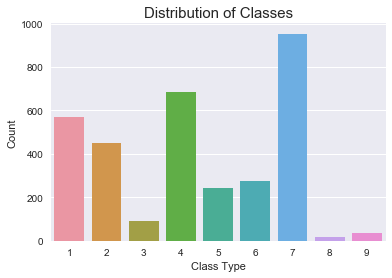

In [6]:
# Distribution of Classes
sns.countplot(x="Class", data = dfv)
plt.title("Distribution of Classes", size = 15)
plt.xlabel('Class Type')
plt.ylabel('Count')

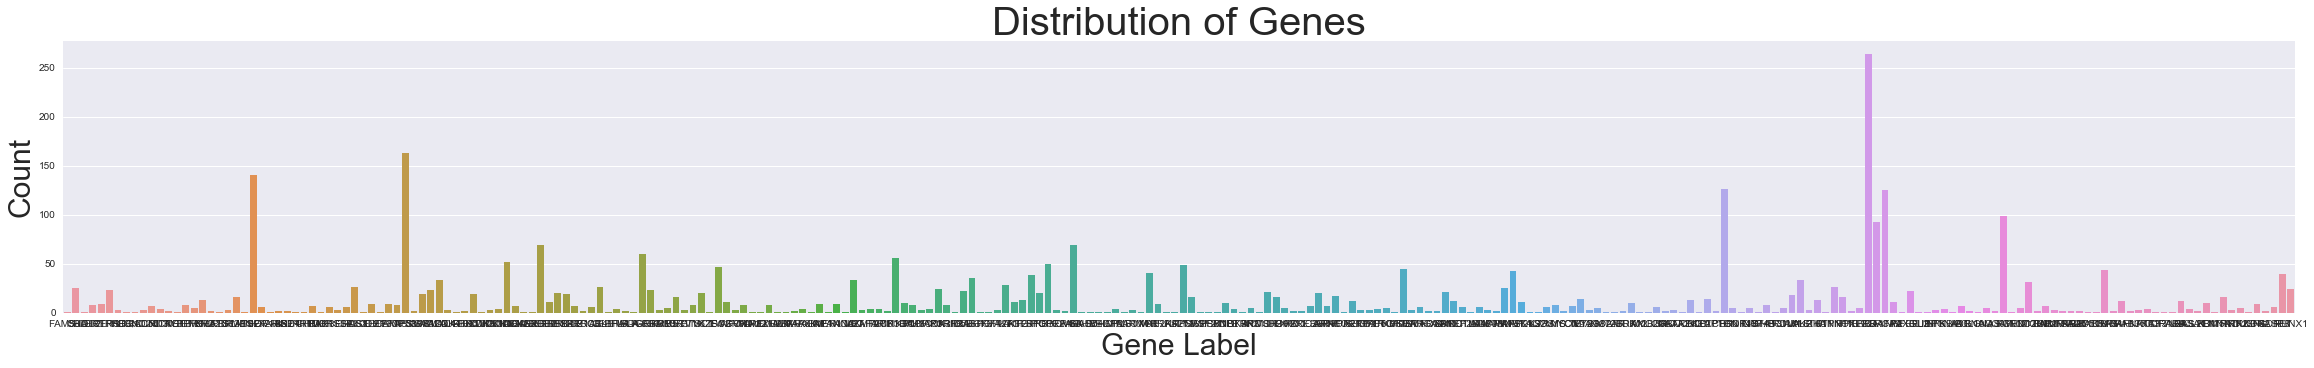

In [7]:
# Distribution of Genes
#dfv.Gene.value_counts().plot(kind='bar', figsize =(40,5))
plt.figure(figsize = (40,5))
sns.countplot(x = 'Gene', data = dfv)
plt.title("Distribution of Genes", size = 40)
plt.xlabel('Gene Label', size = 30)
plt.ylabel('Count', size = 30)


In [8]:
dfv.Gene.value_counts().head()

BRCA1    264
TP53     163
EGFR     141
PTEN     126
BRCA2    125
Name: Gene, dtype: int64

In [9]:
# Distribution of Class within Gene, can be wildly variant

dfv[dfv['Gene'] == 'BRCA1'].Class.value_counts()

5    90
1    60
6    53
4    46
3    15
Name: Class, dtype: int64

In [10]:
dfv[dfv['Gene'] == 'TP53'].Class.value_counts()

1    83
4    67
6     5
2     3
5     2
3     2
9     1
Name: Class, dtype: int64

In [11]:
# Distribution of Variation within class is either all equal 1 or very concentrated in 1-2 Variations
dfv[dfv['Class'] == 1].Variation.value_counts().head(10)

Truncating Mutations    89
Deletion                57
Fusions                  2
C277W                    1
M1689T                   1
A159T                    1
P1311T                   1
V157F                    1
R1076C                   1
S428F                    1
Name: Variation, dtype: int64

In [12]:
dfv[dfv['Class'] == 3].Variation.value_counts().head(10)

N181S     1
I122V     1
E839K     1
S562L     1
P47S      1
I834V     1
S186Y     1
R133H     1
G829R     1
G1286R    1
Name: Variation, dtype: int64

In [13]:
dfv[dfv['Class'] == 7].Variation.value_counts().head(10)

Amplification        40
Overexpression        4
G12V                  4
Q61R                  3
Q61L                  3
E17K                  3
T286A                 2
G12D                  2
G12S                  2
ETV6-NTRK3 Fusion     2
Name: Variation, dtype: int64

In [4]:
dft.iloc[0][1]

"qCyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK

In [5]:
dfv.Class.value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

# Inital Modeling Work

In [14]:
df = pd.merge(dfv, dft, how = 'inner', on = 'ID')

In [15]:
df_small = df[:10]
#pd.to_pickle(df_small, '../Project-three-mcnulty/sample.pkl')

In [16]:
y = df[['ID', 'Class']]
x = df[['ID', 'Text']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.25)

In [17]:
text = list(x_train.Text)

In [18]:
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))
doc_vectors = vectorizer.fit_transform(text)
classes = np.array(y_train.Class)
test_vector = vectorizer.transform(x_test.Text)

In [19]:
# Multinomial Naive Bayes
model = MultinomialNB().fit(doc_vectors, classes)
predictions = model.predict(test_vector)

testing_NB = pd.merge(x_test, y_test, on='ID').dropna(how='all')
predict_NB = pd.concat([testing_NB, pd.Series(predictions)], axis = 1)
predict_NB.columns = ['ID', 'Text', 'Class', 'Predicted']
accuracy_NB = len(list(predict_NB[predict_NB.Class == predict_NB.Predicted].Class))/len(list(predict_NB.Class))


In [ ]:
# Support Vector Classifier
model = LinearSVC().fit(doc_vectors, classes)
predictions = model.predict(test_vector)

testing_SVC = pd.merge(x_test, y_test, on='ID').dropna(how='all')
predict_SVC = pd.concat([testing_SVC, pd.Series(predictions)], axis = 1)
predict_SVC.columns = ['ID', 'Text', 'Class', 'Predicted']
accuracy_SVC = len(list(predict_SVC[predict_SVC.Class == predict_SVC.Predicted].Class))/len(list(predict_SVC.Class))


In [ ]:
# Support Vector Classifier, return probability
model = SVC(kernel = 'linear', probability = True).fit(doc_vectors, classes)
predictions = model.predict_proba(test_vector)

testing_SVC1 = pd.merge(x_test, y_test, on='ID').dropna(how='all')
SVC1predictions = pd.DataFrame(predictions)
predict_SVC1 = pd.merge(testing_SVC1.reset_index(), SVC1predictions.reset_index(), on ='index')
predict_SVC1.columns = ['ID', 'Text', 'Class', 'Predicted', 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# Random Forest Classifier
model = RandomForestClassifier(n_estimators = 20).fit(doc_vectors, classes)
predictions = model.predict(test_vector)

testing_RF = pd.merge(x_test, y_test, on='ID').dropna(how='all')
predict_RF = pd.concat([testing_RF, pd.Series(predictions)], axis = 1)
predict_RF.columns = ['ID', 'Text', 'Class', 'Predicted']
accuracy_RF = len(list(predict_RF[predict_RF.Class == predict_RF.Predicted].Class))/len(list(predict_RF.Class))


In [ ]:
feature_importances = pd.DataFrame(model.feature_importances_)

decisionpath = model.decision_path(test_vector)
decisions = pd.DataFrame(decisionpath[0].toarray())

In [ ]:
# Check some out-of-the-box accuracies
print('Naive Bayes Accuracy: %r' %accuracy_NB)
print('Support Vector Accuracy: %r' %accuracy_SVC)
print('Random Forest Accuracy: %r' %accuracy_RF)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


In [ ]:
ysmall = df_small[['ID', 'Class']]
xsmall = df_small[['ID', 'Text']]
xsmall_train, xsmall_test, ysmall_train, ysmall_test = train_test_split(xsmall, ysmall, test_size =0.25)

textsmall = list(xsmall_train.Text)

In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))
doc_vectors_small = vectorizer.fit_transform(textsmall)
classes_small = np.array(ysmall_train.Class)
test_vector_small = vectorizer.transform(xsmall_test.Text)

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'n_estimators': [10, 20],
    'max_features': ['sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=3)
CV_rfc.fit(doc_vectors_small, classes_small)
print(CV_rfc.best_params_)

In [5]:
dft.iloc[0][1]



"qCyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK